<a href="https://colab.research.google.com/github/UmeshanUC/.NETcore-WinForms-CRUD-Sample-App/blob/master/RuleBasedSystem_with_IoT-with_combined_intents_for_iot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-Loadings

In [22]:
!pip uninstall -y tensorflow
!pip install tensorflow==2.10.0

Found existing installation: tensorflow 2.10.0
Uninstalling tensorflow-2.10.0:
  Successfully uninstalled tensorflow-2.10.0
  Using cached tensorflow-2.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (578.0 MB)


In [23]:
# Rule based---> sinhala_preprocessor.py

import re

class SinhalaPreprocessor:

    @classmethod
    def preprocess_sentence(cls, sentence):
        # There are some &quote while the words
        sentence = re.sub(r"&quot", " ", sentence)
        # - and long hypen should replace with space
        sentence = re.sub(r"([\-–])", " ", sentence)
        # stripe "  සිංහල    භාෂාව " => " සිංහල භාෂාව "
        sentence = sentence.strip()
        # 40,000 -> 40000
        sentence = re.sub(r",000", r"000", sentence)
        # <u>නැගෙනහිර යුරෝපය</u> => නැගෙනහිර යුරෝපය U can be simple or capital
        # Here anything could be between the tag
        sentence = re.sub(r"(<.*?>)+(.*?)(<.*?>)*", r" \2 ", sentence)
        # Here I consider ? . ! , as single words
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        # 100ක් -> 100 ක්
        sentence = re.sub(r"([\d]+)", r" \1 ", sentence)
        # remove `~@#$%^&*()_+=/><':;}{[]|\ “‘
        sentence = re.sub(r"([“‘`~@#$%^&*()_+=/><':;}{\[\]\\|])", "", sentence)
        # remove double quotes
        sentence = re.sub(r'[" "]+', " ", sentence)
        return sentence

    @classmethod
    def preprocess_sentences(cls, sentences):
        new_sentences = []
        for sentence in sentences:
            new_sentences.append(cls.preprocess_sentence(sentence))
        return new_sentences

In [24]:
import random
import json
import pickle
import numpy as np
from tensorflow import keras
from pathlib import Path

In [25]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

replicas = strategy.num_replicas_in_sync
print("REPLICAS: {}".format(replicas))

Running on TPU ['10.25.232.106:8470']


REPLICAS: 8


## Training

In [88]:
# parameters
TRAINING_RATIO = 0.8

In [89]:
# Rule based --> training.py
import random
import pandas as pd

def sinhala_splitter(words):
    return words.split(" ")


intents = json.loads(open(f'intents2.json', encoding="utf8").read())

words = []
classes = []
documents = []
prepocessor = SinhalaPreprocessor()


for intent in intents['intents']:
    for pattern in intent['patterns']:
        # tokenize each word
        w = sinhala_splitter(prepocessor.preprocess_sentence(pattern))
        # add to our words list
        words.extend(w)
        # add to documents in our corpus
        documents.append((w, intent['tag']))
        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])


words = sorted(set(words))
classes = sorted(set(classes))

pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

training = []
output_empty = [0] * len(classes)

for doc in documents:
    bag = []
    word_patterns = doc[0]
    for word in words:
        bag.append(1) if word in word_patterns else bag.append(0)

        output_row = list(output_empty)
        output_row[classes.index(doc[1])] = 1
        training.append([bag, output_row])

random.shuffle(training)
# training = np.array(training)


train_x = [row[0] for row in training]
train_y = [row[1] for row in training]

print(train_x[0:1])
print(train_y[0:1])

# random.shuffle(train_x)
# random.shuffle(train_y)

# print(train_x[0:1])
# print(train_y[0:1])


# train_x = list(training[:, 0])
# train_y = list(training[:, 1])

with strategy.scope():
  model = keras.Sequential()
  model.add(keras.layers.Dense(128, input_shape=(
      len(train_x[0]),), activation='relu'))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(len(train_y[0]), activation='softmax'))

  sgd = keras.optimizers.legacy.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(loss='categorical_crossentropy',
                optimizer=sgd, metrics=['accuracy'])
  model.summary()

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[0, 0, 1, 0, 0, 0, 0]]
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 128)               19840     
                                                                 
 dropout_32 (Dropout)        (None, 128)               0         
                                                                 
 dense_49 (Dense)            (None, 64)                8256      
                          

In [90]:
hist = model.fit(np.array(train_x), np.array(train_y),
                  epochs=50, batch_size=8*replicas, verbose=1, validation_split=TRAINING_RATIO)
model.save('chatbot_model.h5', hist)
print("done")

Epoch 1/50
42/42 [==============================] - 8s 104ms/step - loss: 1.5352 - accuracy: 0.4490 - val_loss: 1.2335 - val_accuracy: 0.4820
Epoch 2/50
42/42 [==============================] - 2s 57ms/step - loss: 1.1310 - accuracy: 0.5767 - val_loss: 0.9007 - val_accuracy: 0.6754
Epoch 3/50
42/42 [==============================] - 2s 56ms/step - loss: 0.8634 - accuracy: 0.7085 - val_loss: 0.6225 - val_accuracy: 0.8025
Epoch 4/50
42/42 [==============================] - 3s 62ms/step - loss: 0.6446 - accuracy: 0.7973 - val_loss: 0.4253 - val_accuracy: 0.8602
Epoch 5/50
42/42 [==============================] - 3s 66ms/step - loss: 0.4889 - accuracy: 0.8455 - val_loss: 0.2903 - val_accuracy: 0.9304
Epoch 6/50
42/42 [==============================] - 3s 65ms/step - loss: 0.3684 - accuracy: 0.8970 - val_loss: 0.1991 - val_accuracy: 0.9758
Epoch 7/50
42/42 [==============================] - 2s 57ms/step - loss: 0.2947 - accuracy: 0.9272 - val_loss: 0.1367 - val_accuracy: 1.0000
Epoch 8/50
4

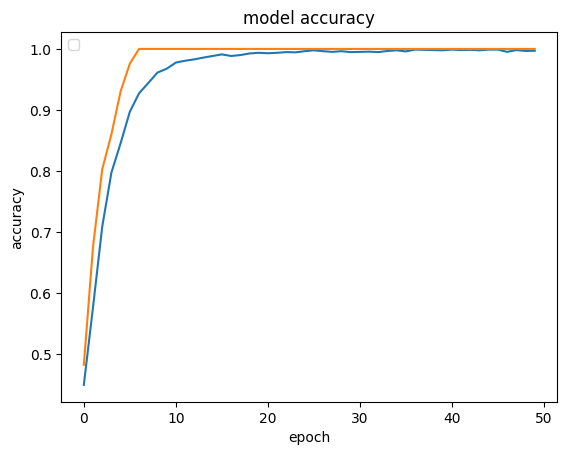

<Figure size 640x480 with 0 Axes>

In [91]:
import matplotlib.pyplot as plt
# set other hyperparams also
plt.legend(['train', 'test'], loc='upper left')
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

fig1 = plt.gcf()
# fig1.savefig('graph.png', dpi=100)
plt.savefig( "graph" + '.png', bbox_inches='tight')

plt.show()
plt.draw()

# from google.colab import files
# files.download("graph.png")

In [92]:
intents = json.loads(
    open(f"intents2.json", encoding="utf8").read())

words = pickle.load(open(f"words.pkl", 'rb'))
classes = pickle.load(open(f"classes.pkl", 'rb'))
model = keras.models.load_model(f"chatbot_model.h5")




def clean_up_sentence(sentence):
    sentence_words = sentence.split()
    sentence_words = [word.lower() for word in sentence_words]
    return sentence_words



def bow(sentence, words, show_details=True):
    sentence_words = clean_up_sentence(sentence)
    bag = [0] * len(words)
    for s in sentence_words:
        for i, word in enumerate(words):
            if word == s:
                bag[i] = 1
    return (np.array(bag))


def predict_class(sentence):
    p = bow(sentence, words, show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

def get_result(question: str):
    results = predict_class(question)
    if(len(results)==0):
        return "General Conversation"
    tag = results[0]['intent']
    proberbility = results[0]['probability']
    if float(proberbility) >= 0.9486:
        list_of_intents = intents['intents']
        if tag == 'health_bot':
            # result = health_bot.getDiagnoses(question)
            result = "A health issue"
            return result
        for i in list_of_intents:
            if (i['tag'] == tag):
                # if i['has_function']:
                #     result = get_func[tag]()
                # else:
                #     result = random.choice(i['responses'])
                result = random.choice(i['responses'])
                break
        return result
    else:
        # result = predictor.predict(question)
        result = "General conversation"
        return result

In [93]:
def test(query):
  print(query)
  res = get_result(query)
  print(res)
  print("------------------------------\n")




In [94]:
test("ඔයා මොකද මෙහෙ කරන්නේ")
test("ඕක ඔන් කරන්න")
test("ආලෝකය")
test("ලයිට් ඔනේ")
test("කරුවලයි")
test("මෙතන ටිකක් කරුවලයි වගෙ නේද")
test("ලයිට් එක දාන්න")

ඔයා මොකද මෙහෙ කරන්නේ
1/1 [==============================] - 0s 72ms/step

------------------------------

ඕක ඔන් කරන්න
1/1 [==============================] - 0s 33ms/step
<iot>
------------------------------

ආලෝකය
1/1 [==============================] - 0s 34ms/step
<iot>
------------------------------

ලයිට් ඔනේ
1/1 [==============================] - 0s 32ms/step
<iot>
------------------------------

කරුවලයි
1/1 [==============================] - 0s 31ms/step
General conversation
------------------------------

මෙතන ටිකක් කරුවලයි වගෙ නේද
1/1 [==============================] - 0s 31ms/step
<iot>
------------------------------

ලයිට් එක දාන්න
1/1 [==============================] - 0s 31ms/step
<iot>
------------------------------



In [95]:
test("කෝ මෙතන එලිය ?")
test("බල්බය නිවන්න")
test("බල්බය අක්‍රිය කරන්න")
test("බල්බය නිවා දමන්න")
test("බල්බය නිවන්න")

කෝ මෙතන එලිය ?
1/1 [==============================] - 0s 34ms/step
General conversation
------------------------------

බල්බය නිවන්න
1/1 [==============================] - 0s 31ms/step
<iot>
------------------------------

බල්බය අක්‍රිය කරන්න
1/1 [==============================] - 0s 31ms/step
<iot>
------------------------------

බල්බය නිවා දමන්න
1/1 [==============================] - 0s 31ms/step
<iot>
------------------------------

බල්බය නිවන්න
1/1 [==============================] - 0s 32ms/step
<iot>
------------------------------



In [96]:
test("අද උෂ්ණත්වය")
test("අද රස්නිය කීයද")
test("අද රස්නෙ කීයද")

අද උෂ්ණත්වය
1/1 [==============================] - 0s 34ms/step
<iot>
------------------------------

අද රස්නිය කීයද
1/1 [==============================] - 0s 34ms/step
General conversation
------------------------------

අද රස්නෙ කීයද
1/1 [==============================] - 0s 30ms/step
<iot>
------------------------------



In [97]:
test("බල්බය ඕෆ් කරන්න")

බල්බය ඕෆ් කරන්න
1/1 [==============================] - 0s 33ms/step
<iot>
------------------------------

